In [1]:
import subroutines
import network

import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms 

%matplotlib inline 

# 1. Load the data

generate_training_data(data_size, f)
    

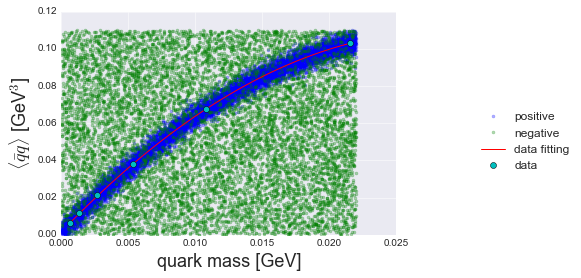

In [2]:
# data values
Hs, Ms = subroutines.return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = subroutines.generate_training_data(data_size=10000, f=f)
# plot
subroutines.plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [3]:
train_d_loader = DataLoader(subroutines.Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [4]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = network.MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
network.init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0]#(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.01*network.eta(i, eta_ini, eta_fin, N_layer)**4)

# 3. Train your NN

/Users/akinoritanaka/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


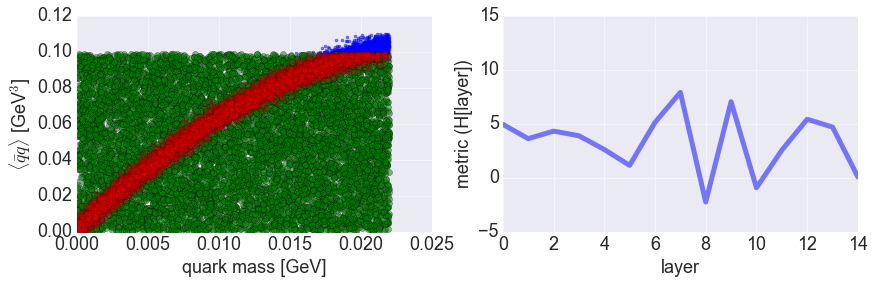

training epoch: 0,   loss: 0.553995935767889
lambda: 0.20836281776428223,   AdS radius: 0.84293532371521[1/GeV]


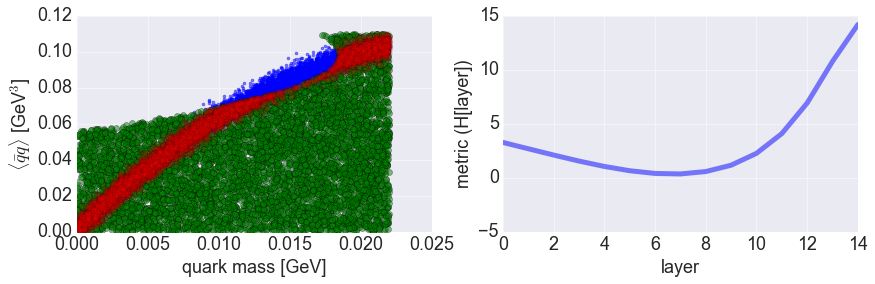

training epoch: 1000,   loss: 0.2128091838210821
lambda: -9.415355682373047,   AdS radius: 1.682712435722351[1/GeV]


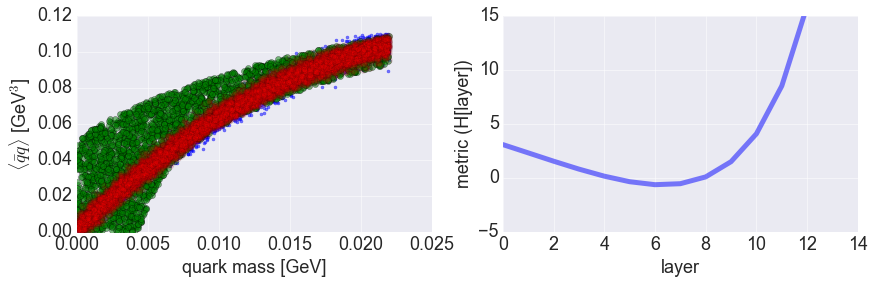

training epoch: 2000,   loss: 0.07748391687870025
lambda: 0.005810469854623079,   AdS radius: 3.974879264831543[1/GeV]


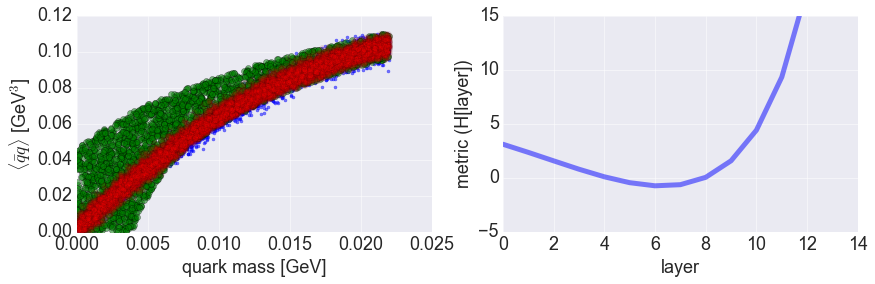

training epoch: 3000,   loss: 0.07473243800923228
lambda: 0.005960123147815466,   AdS radius: 3.8938608169555664[1/GeV]


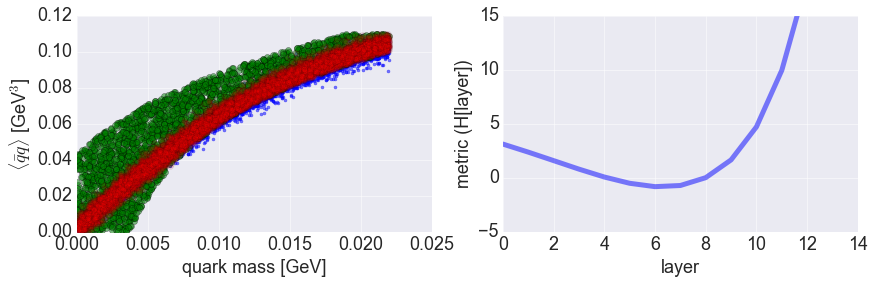

training epoch: 4000,   loss: 0.07568610046058893
lambda: 0.005192625802010298,   AdS radius: 3.852592945098877[1/GeV]


In [5]:
total_epoch=5000
show_epoch_each=1000

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = subroutines.plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
    

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [6]:
%%bash
mkdir trained_models

mkdir: trained_models: File exists


Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [7]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [8]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [9]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

array([[ 3.85264516]], dtype=float32)

In [10]:
model.lamb.weight.data.numpy() # lambda

array([[ 0.00545012]], dtype=float32)

In [11]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)

[[ 3.13351607]]
[[ 2.39271212]]
[[ 1.60696924]]
[[ 0.8100372]]
[[ 0.06195514]]
[[-0.5439406]]
[[-0.87814671]]
[[-0.77317631]]
[[-0.00735563]]
[[ 1.74285817]]
[[ 4.97534227]]
[[ 10.37840176]]
[[ 18.70586967]]
[[ 30.80181313]]
[[ 46.99329758]]
